<a href="https://colab.research.google.com/github/bstrain71/422_bank_marketing/blob/master/Strain_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ingest

In [201]:
# Scikit Learn documentation for this assignment:
# http://scikit-learn.org/stable/auto_examples/classification/
#   plot_classifier_comparison.html
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.score
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.linear_model.LogisticRegression.html
# http://scikit-learn.org/stable/modules/model_evaluation.html 
# http://scikit-learn.org/stable/modules/generated/
#  sklearn.model_selection.KFold.html

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 24601

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection

# initial work with the smaller data set
bank = pd.read_csv('https://raw.githubusercontent.com/bstrain71/422_bank_marketing/master/bank.csv', sep = ';')  # start with smaller data set
# examine the shape of original input data
print(bank.shape)


(4521, 17)


In [12]:

# drop observations with missing data, if any
bank.dropna()
# examine the shape of input data after dropping missing data
# no na wow a miracle
print(bank.shape)


(4521, 17)


## EDA


In [13]:

# look at the list of column names, note that y is the response
list(bank.columns.values)


['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

In [14]:

# look at the beginning of the DataFrame
bank.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [144]:
bank.response.value_counts() # there are 521 yes and 4000 no

no     4000
yes     521
Name: response, dtype: int64

In [18]:

# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(default), np.array(housing), np.array(loan), 
    np.array(response)]).T

# examine the shape of model_data, which we will use in subsequent modeling
print(model_data.shape)
print(model_data[1:10,])

# the rest of the program should set up the modeling methods
# and evaluation within a cross-validation design

# the response variable is in the last column, 3

(4521, 4)
[[0 1 1 0]
 [0 1 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 1 0]]


In [187]:
sum(model_data[:,3])

521

## Modelling

If a simple logistic regression model with L2 regularization is run on the data the model predicts that no one will respond "yes" to the question of whether or not they have subscribed to a term deposit.

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(
  model_data[:,0:2], model_data[:,3],
    stratify = model_data[:,3], random_state=24601)


logreg = LogisticRegression(solver = 'lbfgs').fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

logreg_predictions = pd.DataFrame(logreg.predict(X_test))

logreg_predictions.describe()

Training set score: 0.885
Test set score: 0.885


,0
count,1131.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


Naiive Bayes gave us the same result. We are going to have to tweak some parameters.

In [190]:
sum(y_test)


130

In [191]:
sum(y_train)

391

In [192]:

from sklearn.naive_bayes import BernoulliNB


bayes = BernoulliNB().fit(X_train, y_train)
print("Training set score: {:.3f}".format(bayes.score(X_train, y_train)))
print("Test set score: {:.3f}".format(bayes.score(X_test, y_test)))

bayes_predictions = pd.DataFrame(logreg.predict(X_test))

bayes_predictions.describe()




Training set score: 0.885
Test set score: 0.885


,0
count,1131.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


Neither model is detecting any positives. In light of this both models need the sensitivity increased. Targeted marketing can tolerate, and should expect, some false positives when doing business.

In [0]:
# let's look at the decision function to see if changing the cutoff matters

from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(logreg, X_train, y_train, cv = 3)

confusion_matrix(y_train, y_train_pred)

y_scores = cross_val_predict(logreg, X_train, y_train, cv = 3,
                            method = "decision_function")

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis label, and grid

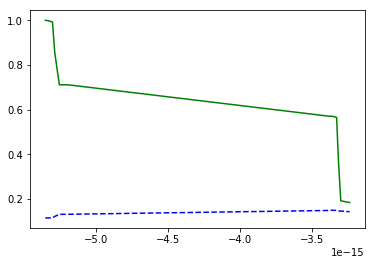

In [211]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## Results